In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tifffile import imread, imsave
import os
from glob import glob
from tqdm import tqdm
import sys

In [5]:
path = 'testSample/'
#os.path.exists(path)
# Load image names
flist = glob(path+'*_ill00.tif')
flist.sort()
print(flist)
shape = (50,512,512)

['testSample/ch00_ill00.tif', 'testSample/ch01_ill00.tif']


In [11]:
# Load images and rescale everything to uint8
imgs=np.stack( [ imread(f) for f in tqdm(flist) ] )
print('Images shape: ',imgs.shape)
print('Image type: ',imgs.dtype)
print('Image memory: ',sys.getsizeof(imgs)/(1024**3))



  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 28.33it/s]

Images shape:  (2, 50, 512, 512)
Image type:  uint16
Image memory:  0.048828259110450745


In [12]:
'''
source:
https://ianlondon.github.io/blog/how-to-sift-opencv/
'''

def gen_sift_features(gray_img):
    sift = cv2.xfeatures2d.SIFT_create()
    # kp is the keypoints
    #
    # desc is the SIFT descriptors, they're 128-dimensional vectors
    # that we can use for our final features
    kp, desc = sift.detectAndCompute(gray_img, None)
    return kp, desc

def show_sift_features(gray_img, color_img, kp, ax):
    return ax.imshow(cv2.drawKeypoints(gray_img, kp, color_img.copy(),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))

# XY registration

In [14]:
mipZ=np.max(imgs,1)
for i in tqdm(list(range(mipZ.shape[0]))):
    _min=np.min(mipZ[i])
    _max=np.percentile(mipZ[i],99.7)
    mipZ[i]=np.clip(mipZ[i],_min,_max)
    mipZ[i]=(2**8-1)*((mipZ[i]-_min)/(_max-_min))
mipZ=mipZ.astype(np.uint8)
mipZ=np.moveaxis(mipZ,0,-1)

print('Max proj shape: ', mipZ.shape)
print('Max proj type: ', mipZ.dtype)
print('Max proj memory: ', sys.getsizeof(mipZ)/(1024**3))



  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 199.15it/s]

Max proj shape:  (512, 512, 2)
Max proj type:  uint8
Max proj memory:  1.1920928955078125e-07


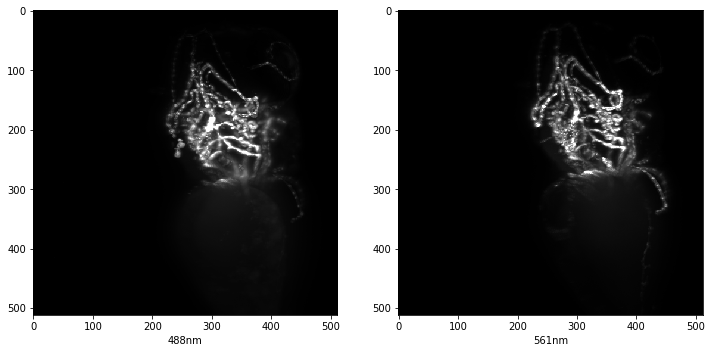

In [16]:
fig,ax=plt.subplots(figsize=(12,12),nrows=1,ncols=2)
ax=ax.flatten()

ch = ['488nm','561nm','647nm','800nm']
for i in range(mipZ.shape[-1]):
    ax[i].imshow(mipZ[...,i],cmap='gray',vmin=0,vmax=255)
    ax[i].set_xlabel(ch[i])

#from tifffile import imsave
#for i in range(4):
#    imsave('mpisOrig_%d.tif'%i,mpis[...,i])

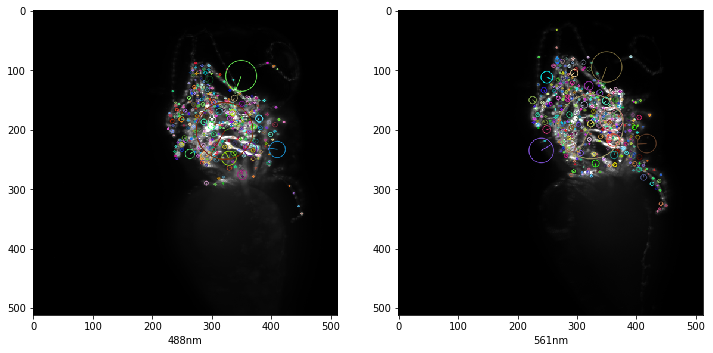

In [17]:
fig,ax=plt.subplots(figsize=(12,12),nrows=1,ncols=2)
ax=ax.flatten()
ch = ['488nm','561nm','647nm','800nm']

kp = [[],[],[],[]]
desc = [[],[],[],[]]
for i in range(mipZ.shape[-1]):
    ax[i].set_xlabel(ch[i])
    kp[i], desc[i] = gen_sift_features(mipZ[...,i])
    show_sift_features(mipZ[...,i], mipZ[...,i], kp[i], ax[i]);

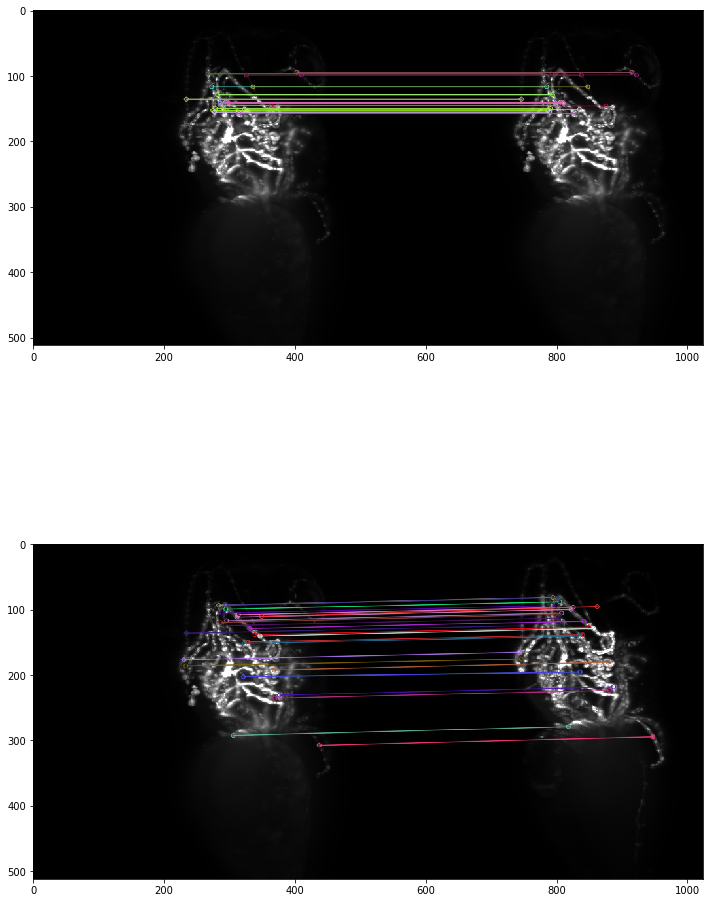

In [19]:
fig,ax=plt.subplots(figsize=(12,18),nrows=2,ncols=1)
ax=ax.flatten()
ch = ['488nm','561nm','647nm','800nm']

bf = cv2.BFMatcher(cv2.NORM_L2,crossCheck=True)

matches = [[],[],[]]
for i in range(mipZ.shape[-1]):
    m=bf.match(desc[0],desc[i])
    m=sorted(m,key=lambda x: x.distance)
    matches[i]=m[:25]
    img=cv2.drawMatches(mipZ[...,0],kp[0],mipZ[...,i],kp[i],matches[i],mipZ[...,i].copy(),flags=2)
    ax[i].imshow(img)

In [20]:
'''
source:
https://www.learnopencv.com/image-alignment-feature-based-using-opencv-c-python/
'''

h = [None,None,None,None]
mask = [None,None,None,None]

for i in range(mipZ.shape[-1]):
    print(i,len(matches[i]),len(kp[i+1]))
    m = matches[i]
    p1 = np.zeros((len(m),2),dtype=np.float32)
    p2 = np.zeros((len(m),2),dtype=np.float32)
    print(p1.shape,p2.shape)
    for j, match in enumerate(m):
#        print(j)
        p1[j,:]=kp[0][match.queryIdx].pt
        p2[j,:]=kp[i][match.trainIdx].pt
    h[i],mask[i]=cv2.findHomography(p2,p1,cv2.RANSAC)
del mask

0 25 519
(25, 2) (25, 2)
1 25 0
(25, 2) (25, 2)


In [21]:
mipZ_XYReg = 0*mipZ
height,width=mipZ[...,0].shape
for i in range(mipZ.shape[-1]):
    mipZ_XYReg[...,i]=cv2.warpPerspective(mipZ[...,i],h[i],(width,height))

(512, 512, 2) uint8


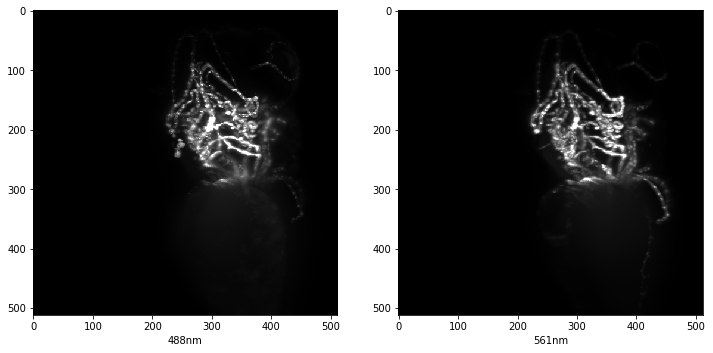

In [24]:
fig,ax=plt.subplots(figsize=(12,12),nrows=1,ncols=2)
ax=ax.flatten()
ch = ['488nm','561nm','647nm','800nm']
for i in range(mipZ_XYReg.shape[-1]):
    ax[i].imshow(mipZ_XYReg[...,i],cmap='gray')
    ax[i].set_xlabel(ch[i])
print(mipZ_XYReg.shape,mipZ_XYReg.dtype)

In [25]:
imgsXYreg = 0*imgs
print(imgsXYreg.shape, imgsXYreg.dtype)

(2, 50, 512, 512) uint16


In [26]:
print('registering in XY...')
for i in tqdm( range(imgsXYreg.shape[1]) ):
    for j in range(mipZ_XYReg.shape[-1]):
        imgsXYreg[j,i] = cv2.warpPerspective(imgs[j,i],h[j],(width,height))



  0%|          | 0/50 [00:00<?, ?it/s]

 16%|█▌        | 8/50 [00:00<00:00, 77.06it/s]

registering in XY...




 50%|█████     | 25/50 [00:00<00:00, 118.87it/s]

 76%|███████▌  | 38/50 [00:00<00:00, 120.74it/s]

100%|██████████| 50/50 [00:00<00:00, 120.62it/s]

In [28]:
#for i in tqdm(range(2)):
#    imsave('ch%02d_ill00_XYreg.tif'%i,imgsXYreg[i])
#del imgs



  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:00<00:00,  1.06it/s]

100%|██████████| 2/2 [00:01<00:00,  1.76it/s]



# XZ registration

In [29]:
from tifffile import imread
#imgsXYreg=np.stack([imread('ch%02d_ill00_XYreg.tif'%i) for i in tqdm(list(range(imgs.shape[0])))])
print('Images shape: ',imgsXYreg.shape)
print('Image type: ',imgsXYreg.dtype)
print('Image memory: ',sys.getsizeof(imgsXYreg)/(1024**3))

Images shape:  (2, 50, 512, 512)
Image type:  uint16
Image memory:  0.048828259110450745


In [30]:
# it's too expensive to resize all images together... max projection of single stack
def resize_stack(instack):    
    _type=instack.dtype
    from skimage.transform import resize
    size=list(instack.shape)
    size[0]*=4
    return resize(instack.astype(np.float64),output_shape=size).astype(_type)

#mipY=np.stack([np.max(resize_stack(stack),2) for stack in tqdm(imgsXYreg[:2])])
mipY=np.stack([resize_stack(np.max(stack,2)) for stack in tqdm(imgsXYreg)])

print('Images shape: ',mipY.shape)
print('Image type: ',mipY.dtype)
print('Image memory: ',sys.getsizeof(mipY)/(1024**3))



  0%|          | 0/2 [00:00<?, ?it/s]/home/local/MORGRIDGE/ngritti/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


 50%|█████     | 1/2 [00:00<00:00,  2.90it/s]

100%|██████████| 2/2 [00:00<00:00,  5.29it/s]

Images shape:  (2, 200, 512)
Image type:  uint16
Image memory:  0.0003815889358520508


In [31]:
# make percentile clipping
for i, mip in enumerate(mipY):
    _min=np.min(mip)
    _max=np.percentile(mip,99.7)
    mip=np.clip(mip,_min,_max)
    mipY[i]=(2**8-1)*((mip-_min)/(_max-_min))
mipY=mipY.astype(np.uint8)
mipY=np.moveaxis(mipY,0,-1)

print('Max proj shape: ', mipY.shape)
print('Max proj type: ', mipY.dtype)
print('Max proj memory: ', sys.getsizeof(mipY)/(1024**3))

Max proj shape:  (200, 512, 2)
Max proj type:  uint8
Max proj memory:  1.1920928955078125e-07


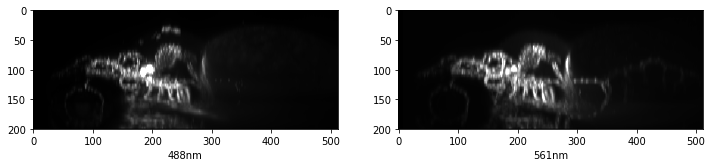

In [32]:
fig,ax=plt.subplots(figsize=(12,12),nrows=1,ncols=2)
ax=ax.flatten()

ch = ['488nm','561nm','647nm','800nm']
for i in range(mipY.shape[-1]):
    ax[i].imshow(mipY[...,i],cmap='gray',vmin=0,vmax=255)
    ax[i].set_xlabel(ch[i])

#from tifffile import imsave
#for i in range(4):
#    imsave('mpisOrig_%d.tif'%i,mpis[...,i])

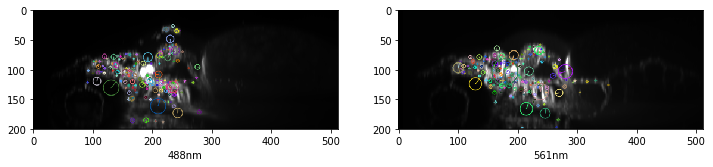

In [33]:
fig,ax=plt.subplots(figsize=(12,12),nrows=1,ncols=2)
ax=ax.flatten()
ch = ['488nm','561nm','647nm','800nm']

kp = [[],[],[],[]]
desc = [[],[],[],[]]
for i in range(mipY.shape[-1]):
    ax[i].set_xlabel(ch[i])
    kp[i], desc[i] = gen_sift_features(mipY[...,i])
    show_sift_features(mipY[...,i], mipY[...,i], kp[i], ax[i]);

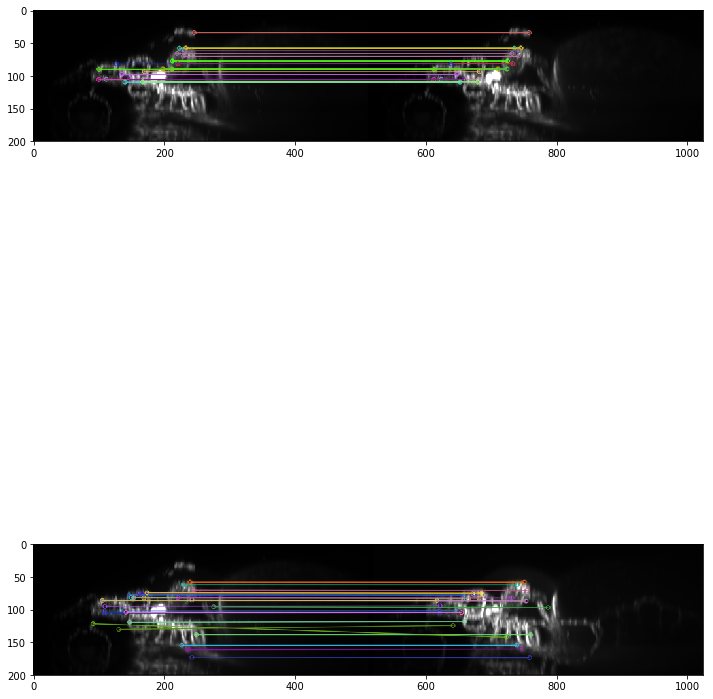

In [35]:
fig,ax=plt.subplots(figsize=(12,18),nrows=2,ncols=1)
ax=ax.flatten()
ch = ['488nm','561nm','647nm','800nm']

bf = cv2.BFMatcher(cv2.NORM_L2,crossCheck=True)

matches = [[],[],[]]
for i in range(mipY.shape[-1]):
    m=bf.match(desc[0],desc[i])
    m=sorted(m,key=lambda x: x.distance)
    matches[i]=m[:25]
    img=cv2.drawMatches(mipY[...,0],kp[0],mipY[...,i],kp[i],matches[i],mipY[...,i].copy(),flags=2)
    ax[i].imshow(img)

In [41]:
'''
source:
https://www.learnopencv.com/image-alignment-feature-based-using-opencv-c-python/
'''

h = [None,None,None,None]
mask = [None,None,None,None]

for i in range(mipY.shape[-1]):
    print(i,len(matches[i]),len(kp[i]))
    m = matches[i]
    p1 = np.zeros((len(m),2),dtype=np.float32)
    p2 = np.zeros((len(m),2),dtype=np.float32)
    print(p1.shape,p2.shape)
    for j, match in enumerate(m):
#        print(j)
        p1[j,:]=kp[0][match.queryIdx].pt
        p2[j,:]=kp[i][match.trainIdx].pt
    h[i],mask[i]=cv2.findHomography(p2,p1,cv2.RANSAC)
del mask

0 25 205
(25, 2) (25, 2)
1 25 195
(25, 2) (25, 2)


In [42]:
mipY_XZReg = 0*mipY
height,width=mipY[...,0].shape
for i in range(mipY.shape[-1]):
    mipY_XZReg[...,i]=cv2.warpPerspective(mipY[...,i],h[i],(width,height))

uint8 [[ 9.97453429e-01 -5.30122729e-02  3.04446969e+00]
 [-6.05688882e-03  9.74916798e-01  1.59726627e+00]
 [ 1.24974574e-05 -1.96770878e-04  1.00000000e+00]]


(200, 512, 2) uint8


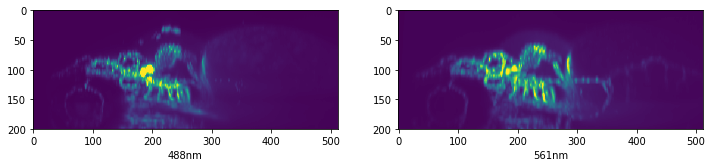

In [44]:
fig,ax=plt.subplots(figsize=(12,12),nrows=1,ncols=2)
ax=ax.flatten()
ch = ['488nm','561nm','647nm','800nm']
for i in range(mipY_XZReg.shape[-1]):
    ax[i].imshow(mipY_XZReg[...,i])
    ax[i].set_xlabel(ch[i])
print(mipY_XZReg.shape,mipY_XZReg.dtype)

In [58]:
imgsXYZreg = np.zeros((2,50,512,512)).astype(np.uint16)
print(imgsXYZreg.shape, imgsXYZreg.dtype)

(2, 50, 512, 512) uint16


4624 4368 4337
uint16
uint16


/home/local/MORGRIDGE/ngritti/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


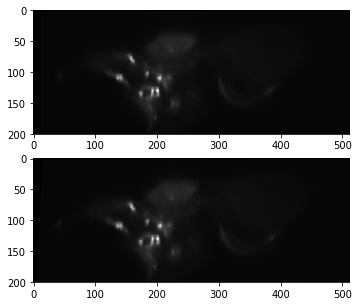

In [59]:
fig,ax=plt.subplots(figsize=(10,5),nrows=2,ncols=1)
tmp=resize_stack(imgsXYreg[1,...,256])
tmpReg=cv2.warpPerspective(tmp,h[1],(width,height))
height,width=tmp.shape
ax[0].imshow(tmp,cmap='gray')
ax[1].imshow(tmpReg,cmap='gray')
print(np.max(imgsXYreg[1,...,256]),np.max(tmp),np.max(tmpReg))
print(imgsXYreg.dtype)
print(tmp.dtype)

In [63]:
print('registering in XZ...')
for j in range(imgsXYZreg.shape[0]):
    for i in tqdm(list(range(imgsXYZreg.shape[-1]))):
        tmp=resize_stack(imgsXYreg[j,...,i])
        height,width=tmp.shape
#        print(width,height)
        imgsXYZreg[j,...,i] = cv2.warpPerspective(tmp,h[j],(width,height))[::4]
#    imsave('ch%02d_ill00_XYZreg.tif'%j,imgsXYZreg[j])



  0%|          | 0/512 [00:00<?, ?it/s]/home/local/MORGRIDGE/ngritti/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


  2%|▏         | 10/512 [00:00<00:05, 98.99it/s]

registering in XZ...




  5%|▍         | 24/512 [00:00<00:04, 119.07it/s]

  8%|▊         | 40/512 [00:00<00:03, 130.69it/s]

 11%|█         | 56/512 [00:00<00:03, 137.29it/s]

 14%|█▍        | 72/512 [00:00<00:03, 141.37it/s]

 17%|█▋        | 88/512 [00:00<00:02, 143.41it/s]

 20%|██        | 104/512 [00:00<00:02, 144.89it/s]

 24%|██▎       | 121/512 [00:00<00:02, 146.89it/s]

 27%|██▋       | 137/512 [00:00<00:02, 147.94it/s]

 30%|██▉       | 153/512 [00:01<00:02, 148.82it/s]

 33%|███▎      | 169/512 [00:01<00:02, 149.65it/s]

 36%|███▌      | 185/512 [00:01<00:02, 150.44it/s]

 39%|███▉      | 201/512 [00:01<00:02, 149.89it/s]

 42%|████▏     | 217/512 [00:01<00:01, 150.30it/s]

 46%|████▌     | 233/512 [00:01<00:01, 150.02it/s]

 49%|████▊     | 249/512 [00:01<00:01, 150.49it/s]

 52%|█████▏    | 266/512 [00:01<00:01, 151.19it/s]

 55%|█████▌    | 282/512 [00:01<00:01, 151.44it/s]

 58%|█████▊    | 298/512 [00:01<00:01, 151.86it/s]

 61%|██████▏   | 314/512 [00:02<00:01, 151.82it/s]

 64%|██████▍   

In [62]:
#for i in tqdm(range(4)):
#    imsave('ch%02d_ill00_XYZreg.tif'%i,imgsXYZreg[i])
#del imgs



  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.47it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.46it/s]



IndexError: index 2 is out of bounds for axis 0 with size 2

In [34]:
h[0]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])





 50%|████▉     | 1015/2048 [01:24<01:25, 12.08it/s]